# Resnet DNN for Fashion MNIST Dataset

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Add, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import seaborn as sns

In [66]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_flat = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test_flat = x_test.reshape(-1, 784).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [67]:
def create_resnet_dnn():
    inputs = layers.Input(shape=(784,))
    
    x = layers.BatchNormalization()(inputs)
    # Initial dense layer
    x = layers.Dense(784, activation='relu')(inputs)
    
    # Residual block 1
    x1 = layers.Dense(784, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x1 = layers.Dropout(0.6)(x1)
    x2 = layers.Dense(784, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x1)
    res1 = layers.Add()([x, x2])  # Skip connection
    res1 = layers.Activation('relu')(res1)
    res1 = layers.Dropout(0.5)(res1)
    
    # Residual block 2
    x3 =layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(res1)
    x3 = layers.Dropout(0.4)(x3)
    x4 = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x3)
    # Need to match dimensions for the skip connection
    res1_down = layers.Dense(1024, activation='relu')(res1)  # Projection to match dimensions
    res2 = layers.Add()([res1_down, x4])
    res2 = layers.Activation('relu')(res2)
    res2 = layers.Dropout(0.4)(res2)


    # Residual block 3
    x5 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(res2)
    x5 = layers.Dropout(0.3)(x5)
    x6 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x5)
    res2_down = layers.Dense(512, activation='relu')(res2)
    res3 = layers.Add()([res2_down, x6])
    res3 = layers.Activation('relu')(res3)
    res3 = layers.Dropout(0.3)(res3)

    
    # Final layers
    x_final = layers.Dense(256, activation='relu')(res3)
    x_final = layers.Dense(128, activation='relu')(x_final) 
    x_final = layers.Dense(64, activation='relu')(x_final)      
    outputs = layers.Dense(10, activation='softmax')(x_final)
    
    return Model(inputs, outputs)

In [68]:
resnet = create_resnet_dnn()

resnet.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)

callbacks=[early_stop, lr_schedule]
history_resnet = resnet.fit(x_train_flat, 
                    y_train, 
                    validation_split=0.3,
                    epochs=100, 
                    batch_size=128,
                    callbacks=callbacks,
                    verbose=1
                    )

Epoch 1/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.5510 - loss: 1.2303 - val_accuracy: 0.8193 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 2/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.8268 - loss: 0.5418 - val_accuracy: 0.8409 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 3/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.8472 - loss: 0.4823 - val_accuracy: 0.8607 - val_loss: 0.4420 - learning_rate: 0.0010
Epoch 4/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.8598 - loss: 0.4412 - val_accuracy: 0.8703 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 5/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.8705 - loss: 0.4050 - val_accuracy: 0.8691 - val_loss: 0.4123 - learning_rate: 0.0010
Epoch 6/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.8761 - loss: 0.3853 - val_accuracy: 0.8582 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 7/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.8

In [73]:
resnet_test_loss, resnet_test_acc = resnet.evaluate(x_test_flat, y_test, verbose=0)
print(f"ResNet-style DNN Test Accuracy: {resnet_test_acc:.4f}")


ResNet-style DNN Test Accuracy: 0.8927


In [76]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

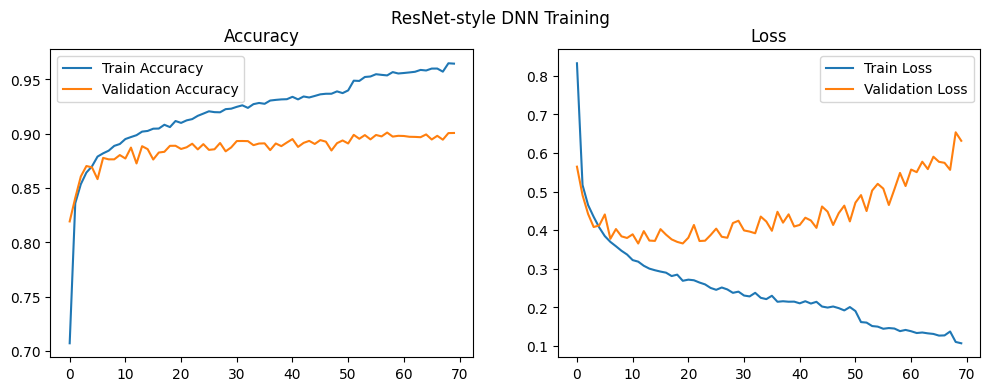

In [77]:
plot_history(history_resnet, 'ResNet-style DNN Training')